In [1]:
import matplotlib.pyplot as plt

from platform import python_version
from scipy import stats

import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import matplotlib

import timeit
from tqdm import tqdm
import random
import os

# import preprocessing tools 
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression as mi
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

# import gaussian process model 
from sklearn.kernel_ridge import KernelRidge

In [2]:
print(os.listdir('DATA'))

train = pd.read_csv("DATA/train.csv").dropna(axis=1)
test = pd.read_csv("DATA/test.csv")

target = np.array(train['SalePrice'].values, np.float)

train.head()

['sample_submission.csv', 'test.csv', 'data_description.txt', 'house-prices-advanced-regression-techniques.zip', 'train.csv']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [3]:
# Neighborhood is an important categorical, nominal feature 
# want to do the ordinal encoding manually 
def OrdinalEncoder(df, features, target='SalePrice'):
    # loop through all categorical features 
    for feature in features:
        neighborhoods = df[feature].values
        prices = []
        # for each feature, determine avg target value
        for neighborhood in np.unique(neighborhoods):
            inds = neighborhood == neighborhoods
            prices.append(np.mean(df.iloc[inds, :][target].values))
        ordinal_labels = np.argsort(prices)
        prices_dict = {neighborhood:i for i, neighborhood in enumerate(np.unique(neighborhoods)[ordinal_labels])}
        # encode categorical features ordinally based on target values 
        encoded_neighborhood = [prices_dict[n] for n in neighborhoods]
        df[feature] = encoded_neighborhood
    return df

In [4]:
# pull out categorical and continuous features 
continuousfeatures = train.describe().columns.values[1:-1] 
categoricalfeatures = [ftr for ftr in train.columns.values[1:-1] if ftr not in continuousfeatures]
features = list(continuousfeatures) + categoricalfeatures

# Assume categorical features are ordinal and encode 
train = OrdinalEncoder(train, categoricalfeatures)

# take decades since 2020 for features that describe the year 
yearfeatures = [f for f in features if 'Year' in f or 'Yr' in f]
train[yearfeatures] = (2020 - train[yearfeatures].values)/ 10

# take square root of features that describe area and divide by max 
areafeatures = [f for f in features if 'SF' in f or 'Area' in f]
train[areafeatures] = train[areafeatures].values**.5 / np.max(train[areafeatures].values**.5, 0)

# set up training data 
X = np.array(train[features].values, np.float)
y = np.array(train['SalePrice'].values, np.float)

# center data 
X = MinMaxScaler((-1, 1)).fit(X).transform(X)

# actually predict centered log_y 
y = np.log(y) - np.mean(np.log(y))

# set up a dataframe with features and target variables 
train[features] = X 
train['SalePrice'] = y
X_df = train[features]
y_df = train['SalePrice']

In [5]:
# set up training params
n_splits_1 = 24
n_splits_2 = 6

# set up out of fold predictions
oof = np.zeros(len(X_df))

# split data into 10 train+validation and testing data sets
skf1 = KFold(n_splits=n_splits_1, shuffle=True, random_state=123)
skf1.get_n_splits(X_df, y_df)
for trainval_index, test_index in skf1.split(X_df):
    # split the whole dataset into training+validation data and testing sets
    X_trainval, X_test = X_df.iloc[trainval_index], X_df.iloc[test_index]
    y_trainval, y_test = y_df.iloc[trainval_index], y_df.iloc[test_index]
    
    skf2 = KFold(n_splits=n_splits_2, shuffle=True, random_state=123)
    skf2.get_n_splits(X_trainval, y_trainval)
    y_pred_mean = 0
    for train_index, val_index in skf2.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # initialize model 
        clf = KernelRidge().fit(X_train, y_train)
        y_pred_mean += clf.predict(X_test) / n_splits_2
        
    # store predictions
    oof[test_index] = y_pred_mean

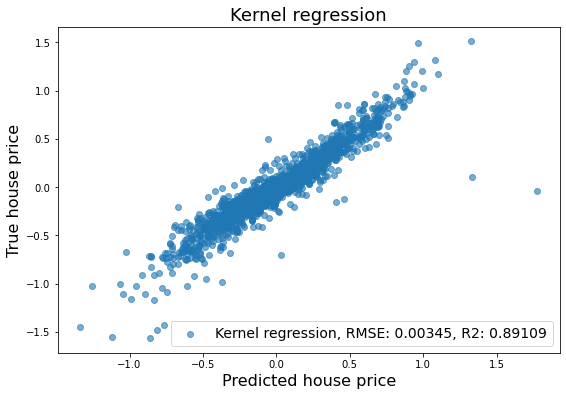

In [6]:
# calculate performance
mse = np.linalg.norm(y - oof)/len(y)
R2 = r2_score(y, oof)

plt.figure(figsize=(9, 6))

plt.scatter(oof, y, alpha=.6, label="Kernel regression, RMSE: {:.5f}, R2: {:.5f}".format(mse, R2))
plt.xlabel("Predicted house price", fontsize=16)
plt.ylabel("True house price", fontsize=16)

plt.legend(fontsize=14)
plt.title("Kernel regression", fontsize=18)
plt.savefig("Figures/KernelRegression.png", dpi=150)
plt.show()